# Graded Challenge 07

# i. Introduction

## a. About Author

Name : Niko Amrullah Hakam

Batch : FTDS - RMT - 038

## b. Problem Statement

Dataset URL : https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data

Internet and Social media platforms have become reflection of human emotions and become a place for people to express their ideas, feelings, and reactions. The sheer amount of data makes analysis a nightmare. Especially when these data are without specifically labelled in such ways so that anyone with specific domain knowledge can make use of them. Understanding people's mental wellbeing based on their posts, for example, is a daunting prospect if done manually.

A model, then, is needed. It should be able to classify passages into categories.

This model might just automate that. Which may help specifically to :
- Detect mental distress from people's posting. 
- Develop chatbots or apps that can help monitor personal mental well being.
- Gather collective emotional trends during significant events. For research and studies on mental health trends.

Justification:

https://iopscience.iop.org/article/10.1088/1757-899X/1099/1/012043

https://www.researchgate.net/publication/372822997_An_Overview_of_the_Application_of_Sentiment_Analysis_in_Mental_Well-being

https://www.sciencedirect.com/science/article/pii/S1877050924031338

Users : Mental Health organizations and professionals, governments, and researchers.

## c. Outlines - Steps

Exploratory will consist of : 
- descriptive statistics which will possibly explore how many words are present in a statement/each datapoint. 
- Furthermore there will be wordclouds (both before and after text-preprocessing).
- Top words by class/category.
- Bi/Trigrams
- Correlation between statement length and sentiments.

ANN Training and ANN Improvement :
- Baseline with minimal parameters and layers.
- Improvement with total of 4 layers. 64 / 32. And some parameters.
- Strength and Weakness can be found at the end of ANN Improvement.

# ii. Import Libraries

In [1]:
# import tensorflow as tf   ## for some reason I had to manually import keras from standalone
import numpy as np
import pandas as pd

import re

import nltk
import contractions
import pickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

from keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import GRU
from keras.backend import clear_session
from keras.initializers import GlorotUniform


from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.model_selection import train_test_split

# import nltk punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Niko Amrullah
[nltk_data]     Hakam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Niko Amrullah
[nltk_data]     Hakam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Niko Amrullah
[nltk_data]     Hakam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Niko Amrullah
[nltk_data]     Hakam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# iii. Data Loading

In [2]:
url = 'https://drive.google.com/uc?id=1oIn_xz891UObGQe8qZITRvnmiQ13aW_P'

In [3]:
# df_ori = pd.read_csv('mental_health.csv')
df_ori = pd.read_csv(url)

In [4]:
df = df_ori.copy()
df

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042       53042  I have really bad door anxiety! It's not about...  Anxiety

[53043 rows x 3 columns]

In [5]:
# drop Unnamed: 0 column, as this is basically just the index
df = df.drop(columns=['Unnamed: 0'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [7]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [8]:
df.duplicated().sum()

1944

In [9]:
# show datapoints with duplicate statementse
df[df.duplicated(subset='statement', keep=False)].sort_values(by='statement')

statement   status
52041  "Buy Friends" comment? My mother doesn't have ...  Anxiety
53027  "Buy Friends" comment? My mother doesn't have ...  Anxiety
49300  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
48420  "Desk Toys for Your Stressful Day!"  \n\nDesk ...   Stress
18     "No regrets or grudges/angry at things that ha...  Anxiety
...                                                  ...      ...
52838                                                NaN  Anxiety
52870                                                NaN  Anxiety
52936                                                NaN  Anxiety
53010                                                NaN  Anxiety
53031                                                NaN  Anxiety

[3373 rows x 2 columns]

In [10]:
df.isna().sum()

statement    362
status         0
dtype: int64

There are 362 datapoints with missing values, which could also be considered as dupes.

There are about 3373 dupes in the dataset

# iv. Exploratory Data Analysis (EDA)

## a. Distribution of Sentiments (`status`)

In [11]:
clear_session()

In [12]:
# show statement column with missing values
df_temp_na = df[df['statement'].isna()]
df_temp_na

statement   status
293         NaN  Anxiety
572         NaN  Anxiety
595         NaN  Anxiety
1539        NaN   Normal
2448        NaN   Normal
...         ...      ...
52838       NaN  Anxiety
52870       NaN  Anxiety
52936       NaN  Anxiety
53010       NaN  Anxiety
53031       NaN  Anxiety

[362 rows x 2 columns]

In [13]:
# group by status and show the mean of the statement column
df_temp_na.groupby('status').size()

status
Anxiety                  47
Bipolar                 100
Normal                    8
Personality disorder    124
Stress                   82
Suicidal                  1
dtype: int64

In [14]:
df_eda = df.copy()

In [15]:
# drop na values and dupes
df_eda = df_eda.dropna()
df_eda = df_eda.drop_duplicates()

These dupes and missing vals can introduce noise during preprocessing steps, such as tokenization, vectorization, or embeddings.

Preprocessing duplicates/missing values wastes computational resources and may create biases later on.

In [16]:
df_eda = df_eda.reset_index(drop=True)

In [17]:
df_eda.isna().sum()

statement    0
status       0
dtype: int64

In [18]:
df_eda.duplicated().sum()

0

In [19]:
count_sent = df_eda['status'].value_counts()
count_sent

status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

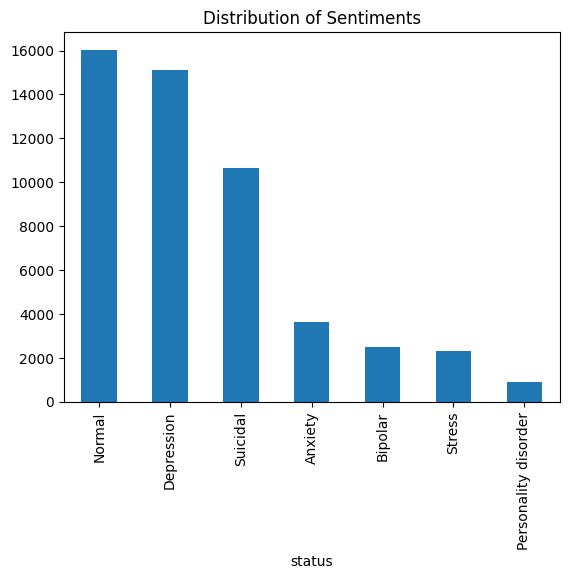

In [20]:
# see the distribution of the sentiment
count_sent.plot(kind='bar', title='Distribution of Sentiments')

Normal dominates, followed by Depression by small margin.

Suicidal comes after.

The last 4 represent only fractions compared to the first 3.

In [21]:
df_eda['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

Our targets for multiclassification

## b. Statement Lenght Distribution

In [22]:
# Text Length Distribution
df_eda['len_statement'] = df_eda['statement'].apply(len)

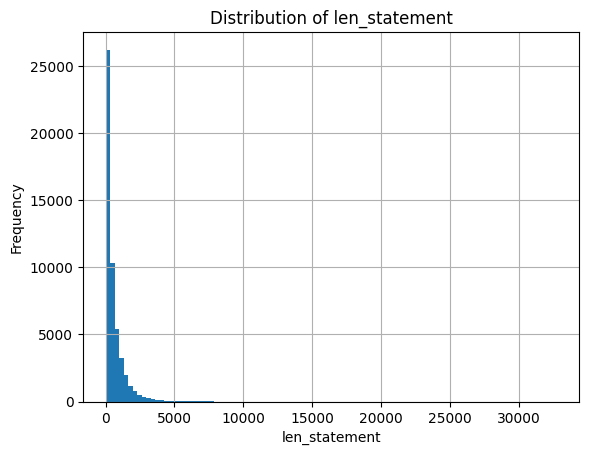

In [23]:
df_eda['len_statement'].hist(bins=100)
plt.title('Distribution of len_statement')
plt.xlabel('len_statement')
plt.ylabel('Frequency')
plt.show()

In [24]:
df_eda['len_statement'].describe()

count    51093.000000
mean       575.600141
std        847.947705
min          2.000000
25%         79.000000
50%        313.000000
75%        745.000000
max      32759.000000
Name: len_statement, dtype: float64

Average length of statements is in 575 words.

With standard defiation 847. Means that some statements have higher amount of words compared to the average.

Minimal words found in a statement is 2

Median is in 313

Maximum number of words is at 32,759. What is it, a thesis?

In [25]:
# show the longest statement
df_eda[df_eda['len_statement'] >= 745]

statement      status  \
6896   I do not know how to navigate these feelings, ...  Depression   
6898   I am so exhausted of this. Just when I think I...    Suicidal   
6899   I have been severly bullied since i was 5 till...  Depression   
6906   Since I began seeing a therapist 5 months ago ...  Depression   
6908   I am on zoloft and focalin and it is changed m...    Suicidal   
...                                                  ...         ...   
51085  Anxiety Over Having Made No Accomplishments in...     Anxiety   
51086  Physical side of Anxiety (Possible emetophobia...     Anxiety   
51087  anxiety progress/my story Hey guys! \n\nI’ve b...     Anxiety   
51090  Travel Anxiety Hi all! Long time anxiety suffe...     Anxiety   
51091  fomo from things i’m not involved in does anyo...     Anxiety   

       len_statement  
6896            1510  
6898            1704  
6899            1006  
6906            2477  
6908             780  
...              ...  
51085           2531  
51086           1285  
51087           2300  
51090            851  
51091            891  

[12792 rows x 3 columns]

In [26]:
# def function to filter out outliers
def filter_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] > lower_bound) & (data[column] < upper_bound)]

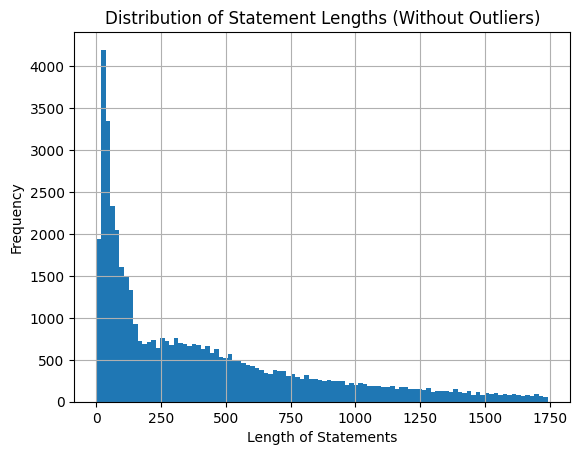

In [27]:
# Filter out the outliers
filtered_df = filter_outliers(df_eda, 'len_statement')
# Plot the distribution of statement lengths without outliers
filtered_df['len_statement'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

### Check these outliers

In [28]:
# def a function to display whole statement from a datapoint without truncation, based on index
def display_full_statement(data, index):
    '''
    Based on index, display the full statement from the dataframe without truncation
    data: dataframe
    index: index of the datapoint
    '''
    print(data['statement'].iloc[index])

In [29]:
# locate the index of the longest statement

index_longest_statement = df_eda[df_eda['len_statement'] == df_eda['len_statement'].max()]

# Display the index
index_longest_statement


statement    status  \
13203  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...  Suicidal   

       len_statement  
13203          32759

In [30]:
ind_13293 = display_full_statement(df_eda, 13203)

I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAKE IT ANYMORE. I cannot TAK

In [31]:
df_eda[df_eda['len_statement'] >= 745].sort_values(by='len_statement', ascending=False).head(20)

statement  \
13203  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...   
49919  Please help me understand what I went through ...   
10745  I have only 1 person I can somewhat open to bu...   
46232  DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...   
9329   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
39386  it doesn t matter anymore i m going to copy an...   
11492  I no longer know what else to do but write thi...   
21761  I constantly repeat to myself that I have neve...   
11547  And has life gotten better?&amp;#x200B;No. Eve...   
11448  The title is not meant to discourage others, b...   
21299  will i ever be noticed? is my life worth anyth...   
22146  I do not expect anyone to read this rambly mes...   
22466  I have been thinking about posting online for ...   
9417   Hello everyone,I rarely post on Reddit but.......   
11742  Sorry this is long but I doubt anyone will eve...   
23718  I need support or encouragement. I (29M) reall...   
23743  This is a a vent. I (29M) really do not know w...   
7764   So introduction I guess.. my name is Michael a...   
18121  I am someone living in Turkey. My age is proba...   
39216  we ve been seeing a worrying increase in pro s...   

                     status  len_statement  
13203              Suicidal          32759  
49919  Personality disorder          27588  
10745              Suicidal          27390  
46232               Bipolar          26163  
9329               Suicidal          25302  
39386            Depression          19822  
11492            Depression          13530  
21761            Depression          13054  
11547            Depression          12819  
11448            Depression          12304  
21299            Depression          12298  
22146              Suicidal          12227  
22466              Suicidal          12028  
9417             Depression          11163  
11742            Depression          11122  
23718            Depression          11111  
23743              Suicidal          11075  
7764             Depression          10679  
18121              Suicidal          10219  
39216            Depression           9983

In [32]:
statement = df_eda['statement'].iloc[13203]
print("Spaces: {}".format(statement.count(' ')))
print("Newlines: {}".format(statement.count('\n')))
print("Tabs: {}".format(statement.count('\t')))

Spaces: 6299
Newlines: 0
Tabs: 0


In [33]:
## Uncomment to save the statement to a text file. Manual inspection.
# with open('inspect_raw_statement.txt', 'w') as f:
#     f.write(df_eda.iloc[9329]['statement'])

## c. WordCloud **BEFORE** Text pre-processing

In [34]:
df_eda['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [35]:
# make some temp df to store data of each class
df_normal = df_eda[df_eda['status'] == 'Normal']
df_depressed = df_eda[df_eda['status'] == 'Depression']
df_suicidal = df_eda[df_eda['status'] == 'Suicidal']
df_anxiety = df_eda[df_eda['status'] == 'Anxiety']
df_bipolar = df_eda[df_eda['status'] == 'Bipolar']
df_stress = df_eda[df_eda['status'] == 'Stress']
df_personal = df_eda[df_eda['status'] == 'Personality disorder']

In [36]:
# combine text of each class
normal_text = ' '.join(df_normal['statement'])
depressed_text = ' '.join(df_depressed['statement'])
suicidal_text = ' '.join(df_suicidal['statement'])
anxiety_text = ' '.join(df_anxiety['statement'])
bipolar_text = ' '.join(df_bipolar['statement'])
stress_text = ' '.join(df_stress['statement'])
personal_text = ' '.join(df_personal['statement'])

In [37]:
# create wordcloud for each class
normal_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(normal_text)
depressed_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(depressed_text)
suicidal_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(suicidal_text)
anxiety_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(anxiety_text)
bipolar_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(bipolar_text)
stress_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(stress_text)
personal_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(personal_text)

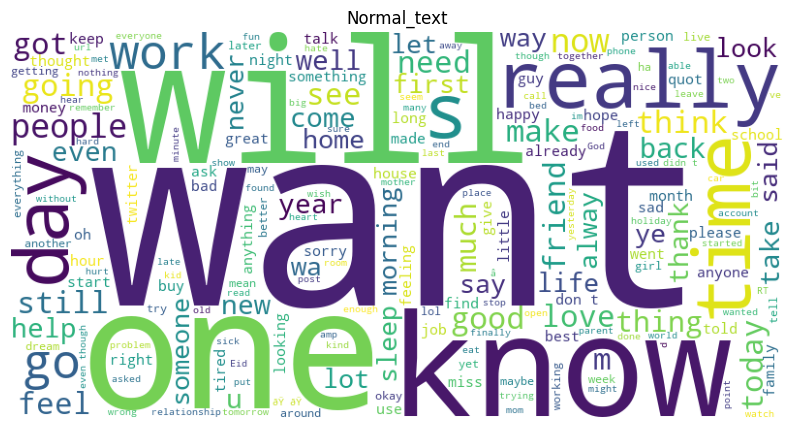

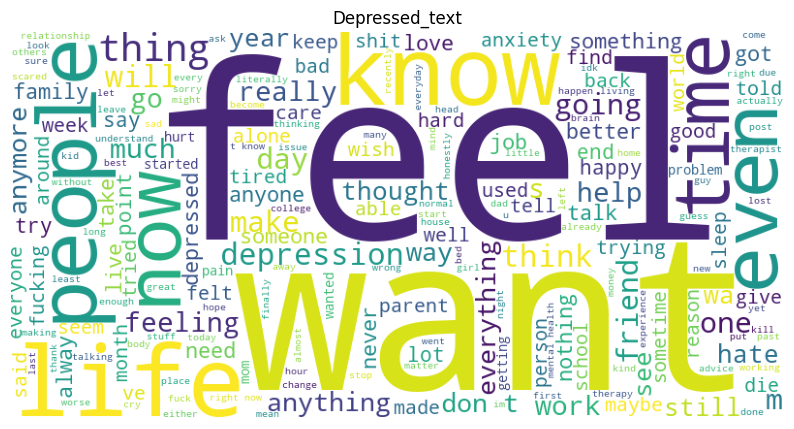

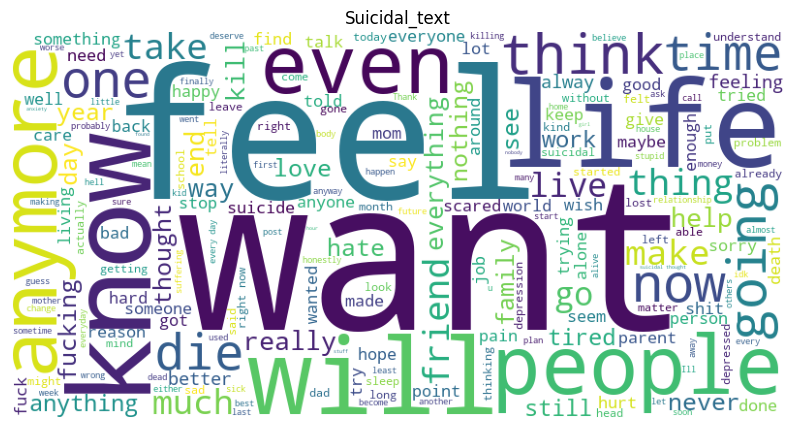

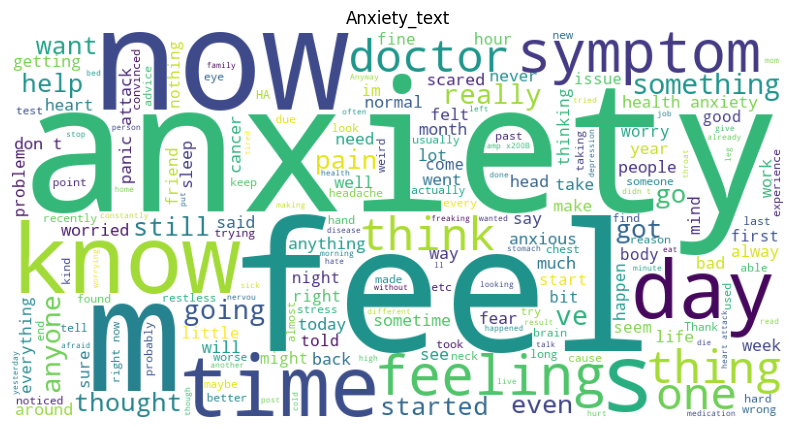

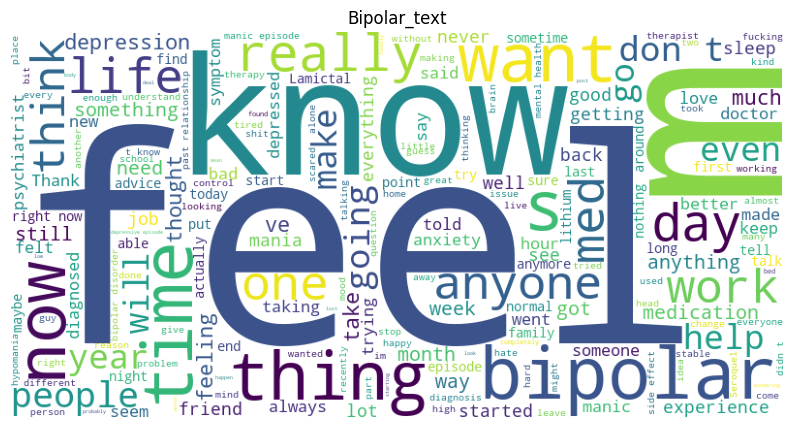

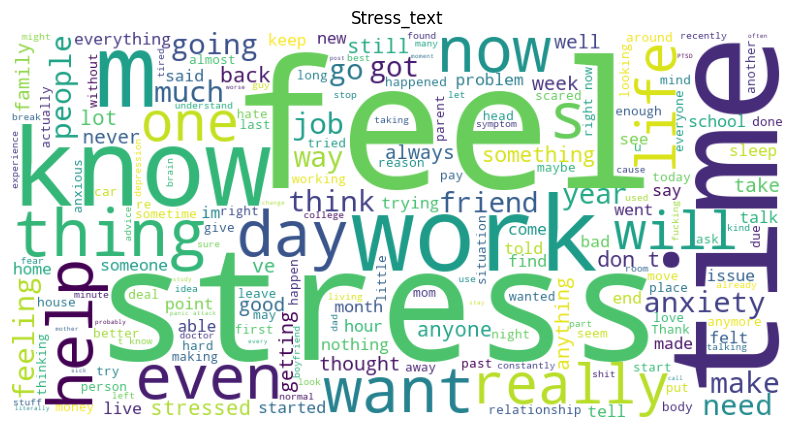

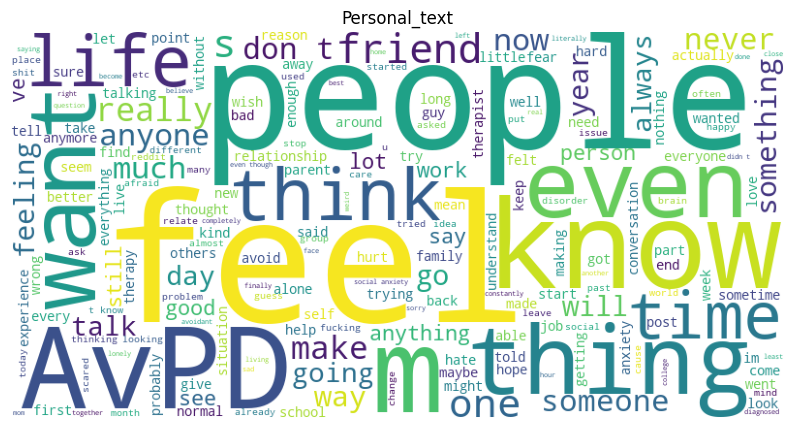

In [38]:
# plot the wordclouds
# Define the word clouds and their titles in a list of tuples
wordclouds = [
    (normal_wordcloud, 'Normal_text'),
    (depressed_wordcloud, 'Depressed_text'),
    (suicidal_wordcloud, 'Suicidal_text'),
    (anxiety_wordcloud, 'Anxiety_text'),
    (bipolar_wordcloud, 'Bipolar_text'),
    (stress_wordcloud, 'Stress_text'),
    (personal_wordcloud, 'Personal_text')
]

# Loop through each word cloud and its title, plotting them
for wordcloud, title in wordclouds:
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

**Normal**:

Common words in Normal include "want," "know," "time," "day," "people," and "good."

These words reflect general conversational patterns, for example : expressing everyday desires, time references, and social interactions.
There is no evident focus on mental health issues or emotional distress, making it distinctly different from other categories.

**Depression**:

Frequently used words include "feel," "life," "people," "want," and "depression."

The emphasis on "feel" and "life" suggests an introspective and emotional focus, often linked to personal struggles.
The presence of words like "depression," "alone," and "nothing" highlights the themes of despair and isolation common in this category.

**Suicidal**:

Key terms are "feel," "want," "life," "die," and "take."

Words such as "die," "kill," and "suicide" are highly alarming and indicative of serious mental health crises.
The reappearence of "feel" and "life" mirrors the other categories but with stronger associations to suicidal ideation.

**Anxiety**:

Common words are "feel," "anxiety," "know," "time," and "symptom."

The frequent mention of "anxiety," "symptom," "think," and "worry" reflects the overwhelming and physical nature of anxiety disorders.
Themes of health concerns (e.g., "doctor," "attack") are also notable, pointing to the anxiety about physical well-being.

**Bipolar**:

Common words include "feel," "bipolar," "know," "time," and "work."

The appearance of "bipolar," "med," and "manic" suggests a focus on mental health diagnosis and treatment.
Words like "life" and "feel" continue to indicate emotional introspection, often associated with mood swings.

**Personality Disorder**:

Frequent words are "feel," "people," "life," "AvPD," and "think."

The abbreviation "AvPD" (likely Avoidant Personality Disorder) is specific to this category, highlighting a focus on specific diagnoses.
Words like "alone," "fear," and "relationship" suggest themes of isolation and interpersonal difficulties.

---

### Key takeways:

#### Emotional Focus
- The words **"feel"** and **"life"** are recurring across most categories, indicating a shared emotional introspection across mental health statuses.
- However, the context around these words (For example, **"depression,"** **"anxiety,"** **"suicide"**) shifts the narrative significantly between categories.

#### Category-Specific Themes
- Categories such as **"Anxiety,"** **"Bipolar,"** and **"Personality Disorder"** display unique terminologies related to specific diagnoses and symptoms, e.g., **"symptom,"** **"med,"** and **"AvPD."** (Avoidant Personality Disorder).
- In contrast, **"Normal"** lacks such targeted vocabulary, emphasizing its uniquenes from the other mental health categories.

#### Actionable Insights
- The presence of highly distressing terms (e.g., **"suicide,"** **"kill,"** **"die"**) in the **"Suicidal"** category can help in prioritizing interventions.

#### Differences in Conversational Context
- **"Normal"** texts are more about day-to-day conversations, while other categories delve into emotional and psychological issues.
- This distinction can be used to build models that differentiate mental health statuses effectively.


---

## d. WordCloud **AFTER** text pre-processing

In [39]:
# Initialize stopwords and stemmer
stpwds_en = list(set(stopwords.words('english')))
stemmer = PorterStemmer()

# init lemmitizer
lemmatizer = WordNetLemmatizer()

In [40]:
# check the most used words for stopwords
df_eda['statement_stop'] = df_eda['statement'].apply(lambda x: str(x).split())
high_all = Counter([item for sublist in df_eda['statement_stop'] for item in sublist])

txt_high_all = pd.DataFrame(high_all.most_common(20), columns=['word', 'count'])

txt_high_all.columns = ['word', 'count']
txt_high_all.style.background_gradient(cmap='Blues')

In [41]:
df_eda.columns

Index(['statement', 'status', 'len_statement', 'statement_stop'], dtype='object')

In [42]:
df_prepro = df_eda.copy()
df_prepro.drop(columns=['len_statement', 'statement_stop'], inplace=True)

In [43]:
stpwds_en.append(["i", "to", "and", "my", "of", "the", "is", "have", "it", "in"])

In [44]:
def text_preprocessing(text):
    # Expand contractions
    text = contractions.fix(text)

    # Case folding
    text = text.lower()

    # Mention removal
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)

    # Hashtag removal
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)

    # Newline removal (\n)
    text = re.sub(r"\\n", " ", text)

    # Whitespace removal
    text = text.strip()

    # URL removal
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"www.\S+", " ", text)

    # Non-letter removal (retain apostrophes)
    text = re.sub(r"[^A-Za-z\s']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords removal
    tokens = [word for word in tokens if word not in stpwds_en or word in {"not", "no", "never", "cannot", "still"}]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combine tokens
    text = ' '.join(tokens)

    return text

In [45]:
df_prepro['cleaned_statement'] = df_prepro['statement'].apply(text_preprocessing)

In [46]:
df_prepro.head(5)

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                   cleaned_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3         shifted focus something else still worried  
4                   restless restless month boy mean

In [47]:
df_prepro['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [48]:
# Concatenate preprocessed text by class
normal_text = " ".join(df_prepro[df_prepro['status'] == 'Normal']['cleaned_statement'])
depressed_text = " ".join(df_prepro[df_prepro['status'] == 'Depression']['cleaned_statement'])
suicidal_text = " ".join(df_prepro[df_prepro['status'] == 'Suicidal']['cleaned_statement'])
anxiety_text = " ".join(df_prepro[df_prepro['status'] == 'Anxiety']['cleaned_statement'])
bipolar_text = " ".join(df_prepro[df_prepro['status'] == 'Bipolar']['cleaned_statement'])
stress_text = " ".join(df_prepro[df_prepro['status'] == 'Stress']['cleaned_statement'])
personal_text = " ".join(df_prepro[df_prepro['status'] == 'Personality disorder']['cleaned_statement'])

In [49]:
# Generate word clouds
normal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(normal_text)
depressed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(depressed_text)
suicidal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(suicidal_text)
anxiety_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(anxiety_text)
bipolar_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bipolar_text)
stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(stress_text)
personal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(personal_text)

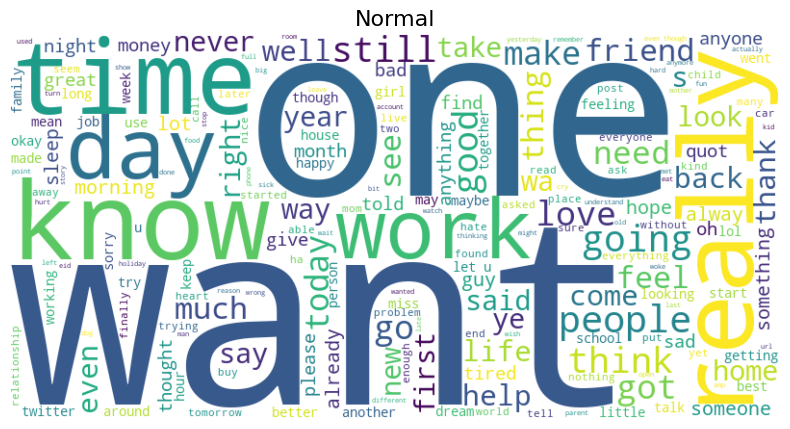

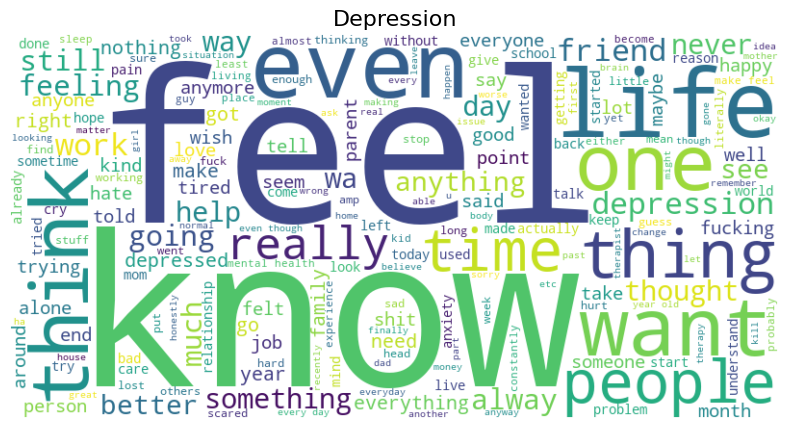

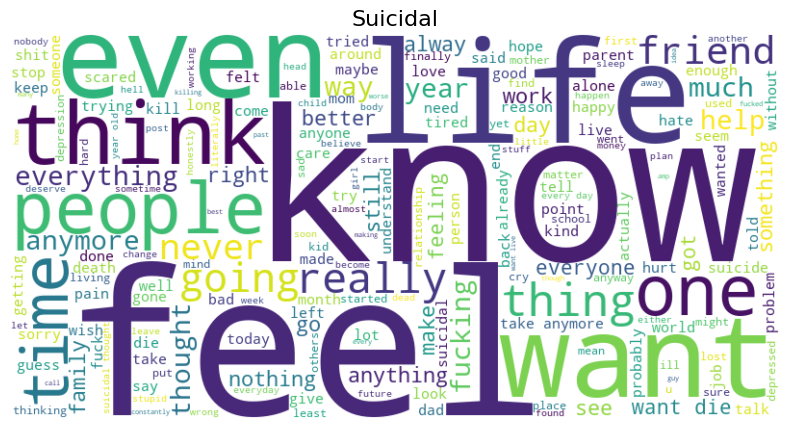

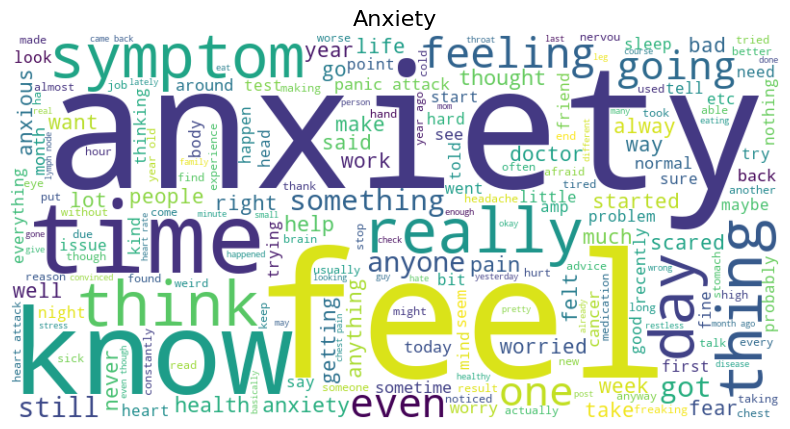

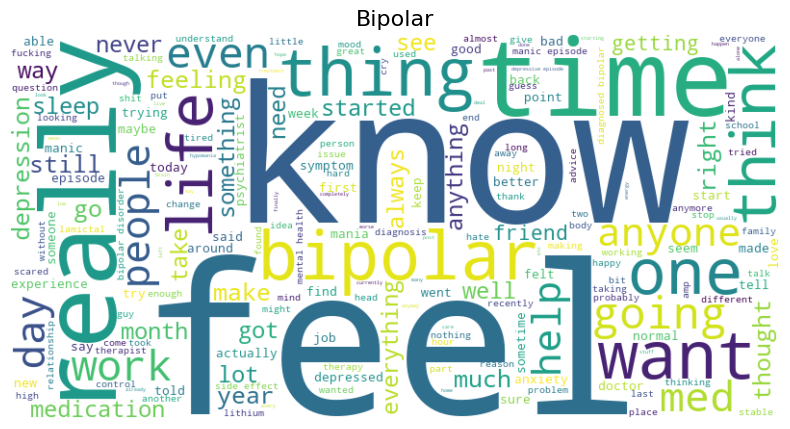

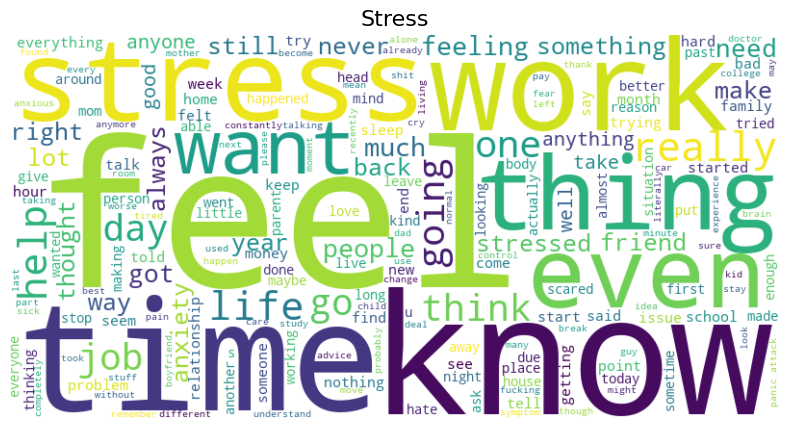

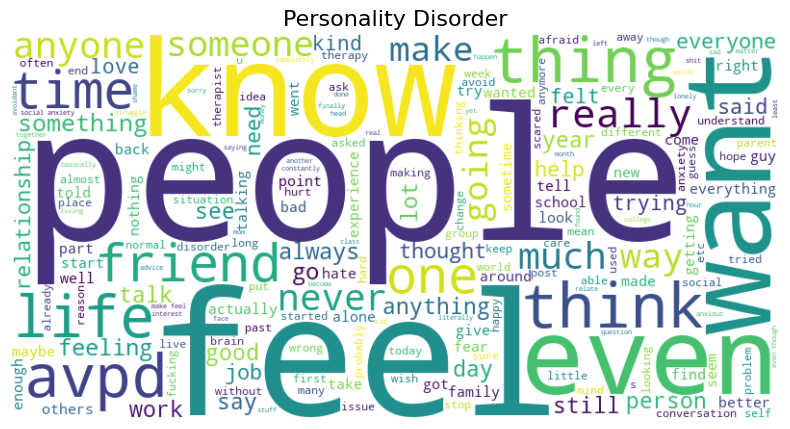

In [50]:
# Plot the word clouds
wordclouds = [
    (normal_wordcloud, 'Normal'),
    (depressed_wordcloud, 'Depression'),
    (suicidal_wordcloud, 'Suicidal'),
    (anxiety_wordcloud, 'Anxiety'),
    (bipolar_wordcloud, 'Bipolar'),
    (stress_wordcloud, 'Stress'),
    (personal_wordcloud, 'Personality Disorder')
]

for wordcloud, title in wordclouds:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

Normal :
**Key Words:** "want," "one," "know," "time," "really," "day," "work."
**Insights:**
- Common themes reflect general desires, daily activities, and introspective thoughts.
- Words like "want" and "know" indicate a focus on personal goals and understanding.
- Social words like "people" and "friend" show interactions and relationships are important.

Depression :
**Key Words:** "life," "feel," "know," "want," "even," "think," "time."
**Insights:**
- Core emotions like "feel" and "life" dominate, reflecting emotional struggles and introspection.
- Words like "even," "think," and "want" highlight a sense of hopelessness and rumination.
- The lemmatization process preserves the emotional depth while clarifying text.

Suicidal:
**Key Words:** "feel," "know," "life," "want," "even," "think," "time."
**Insights:**
- Emotional pain is evident with words like "feel," "life," and "want."
- "Even" and "know" reflect struggles to process thoughts and emotions.
- Preprocessing highlights suicidal ideation themes, but lemmatization reduces noise.

Anxiety:
**Key Words:** "anxiety," "feel," "symptom," "know," "think," "time."
**Insights:**
- "Anxiety" and "symptom" emphasize the health-related focus of this category.
- Words like "feel" and "think" indicate introspection and emotional distress.
- The emphasis on health terms (e.g., "doctor," "health") persists, showing clarity in medical-related concerns.

Bipolar:
**Key Words:** "feel," "know," "time," "bipolar," "think," "want."
**Insights:**
- "Bipolar" remains prominent, highlighting clinical discussions.
- Emotional terms ("feel," "know") and functional terms ("time," "want") suggest a mix of personal and clinical narratives.
- Lemmatization enhances clarity while retaining core themes.

Stress:
**Key Words:** "feel," "work," "time," "stress," "know," "want."
**Insights:**
- The dominance of "stress" and "work" reflects the primary concern of this category.
- Emotional and time-management issues ("feel," "time") highlight the personal impact of stress.
- The word cloud effectively conveys the balance between professional and emotional stressors.

Personality Disorder:
**Key Words:** "feel," "people," "know," "want," "think," "life."
**Insights:**
- "Feel" and "people" dominate, reflecting interpersonal struggles and emotional introspection.
- Words like "want" and "life" emphasize desires and self-reflection.
- The clarity in this category reflects

### Key Takeaways:

#### Core Themes Retained
- Emotional terms like "feel," "know," and "want" remain dominant across categories, showcasing the depth of emotional expression.
- Clinical terms (e.g., "bipolar," "symptom") are preserved in relevant categories, providing specificity.

#### Distinction Between Categories
- **Normal:** Focuses on desires and social interactions.
- **Depression/Suicidal:** Highlights emotional pain and existential struggles.
- **Anxiety:** Emphasizes health and emotional distress.
- **Bipolar/Personality Disorder:** Balances clinical and personal themes.
- **Stress:** A clear blend of professional and personal stressors.


---

From keytakeaways and insights above, we can summurize :

| Category            | Primary Focus                                           |
|---------------------|---------------------------------------------------------|
| Normal              | Desires, aspirations, and social relationships.         |
| Depression          | Emotional pain, isolation, and existential struggles.   |
| Suicidal            | Hopelessness, distress, and urgency for intervention.   |
| Anxiety             | Physical symptoms, emotional distress, and fear of uncertainty. |
| Bipolar             | Clinical discussions and emotional volatility.          |
| Personality Disorder| Interpersonal struggles and self-identity issues.       |
| Stress              | Work-life balance and emotional toll of daily responsibilities. |


---

## e. Top words by category

In [51]:
# Get the most frequent words for each category
def get_top_words(df, category, n=10):
    text = " ".join(df[df['status'] == category]['cleaned_statement'])
    words = text.split()
    return Counter(words).most_common(n)

In [52]:
categories = df_prepro['status'].unique()
for category in categories:
    print(f"Top words for {category}: {get_top_words(df_prepro, category)}")


Top words for Anxiety: [('not', 8133), ('anxiety', 3590), ('like', 3045), ('feel', 2609), ('get', 1979), ('time', 1953), ('know', 1900), ('day', 1751), ('really', 1490), ('year', 1416)]
Top words for Normal: [('not', 4406), ('like', 1298), ('want', 1224), ('time', 925), ('get', 918), ('really', 857), ('would', 808), ('go', 800), ('one', 798), ('know', 797)]
Top words for Depression: [('not', 49375), ('like', 18094), ('feel', 17941), ('want', 12584), ('know', 11957), ('life', 11545), ('get', 10400), ('time', 9521), ('even', 9037), ('no', 8621)]
Top words for Suicidal: [('not', 37796), ('want', 11161), ('like', 9215), ('feel', 8562), ('life', 8204), ('know', 7419), ('no', 6175), ('would', 5742), ('get', 5706), ('even', 5214)]
Top words for Stress: [('not', 4516), ('like', 1510), ('feel', 1307), ('stress', 1157), ('get', 1138), ('time', 1086), ('know', 1021), ('would', 751), ('day', 751), ('work', 727)]
Top words for Bipolar: [('not', 7885), ('like', 2757), ('feel', 2461), ('know', 1789),

## f. Bi/Trigrams

In [53]:
# Bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10)
bigrams = vectorizer.fit_transform(df_prepro['cleaned_statement'])
print(f"Top 10 bigrams: {vectorizer.get_feature_names_out()}")

# Trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=10)
trigrams = vectorizer.fit_transform(df_prepro['cleaned_statement'])
print(f"Top 10 trigrams: {vectorizer.get_feature_names_out()}")

Top 10 bigrams: ['anymore not' 'could not' 'feel like' 'like not' 'no one' 'not even'
 'not feel' 'not know' 'not take' 'not want']
Top 10 trigrams: ['anymore not take' 'feel like not' 'not even know' 'not feel like'
 'not know anymore' 'not know not' 'not take anymore' 'not want die'
 'not want live' 'take anymore not']


"feel like" and "not feel" suggest emotional introspection across categories.

"not want" and "not take" are especially significant in Suicidal and Depression categories, reflecting rejection or aversion.

Phrases like "not want die" and "not want live" are strongly associated with Suicidal ideation, indicating hopelessness and distress.

"feel like not" and "not feel like" highlight uncertainty and negative emotions across categories.

## g. Correlation Between Length and Sentiment

In [54]:
# Assign sentiment to each statement
df_prepro['sentiment'] = df_prepro['cleaned_statement'].apply(lambda x: TextBlob(x).sentiment.polarity)

# assign sentence length
df_prepro['sentence_length'] = df_prepro['cleaned_statement'].apply(lambda x: len(x.split()))

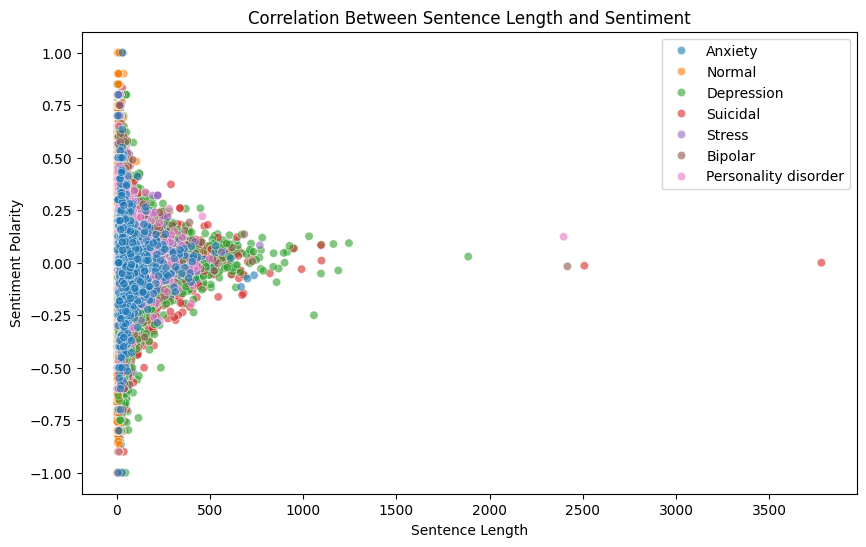

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_length', y='sentiment', hue='status', data=df_prepro, alpha=0.6)
plt.title('Correlation Between Sentence Length and Sentiment')
plt.xlabel('Sentence Length')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.show()

Most sentences cluster around shorter lengths (<500 words), with neutral to slightly positive sentiment polarity.

Longer sentences (>1000 words) appear less frequent but lean toward more negative sentiment, especially for categories like Suicidal and Depression.

Categories such as Anxiety and Stress show a broad range of sentiment polarities, reflecting emotional variability.

> Shorter sentences are prevalent across categories, reflecting concise expressions of thoughts or emotions.

> Longer sentences in Suicidal and Depression categories might indicate individuals trying to articulate complex emotions or distress in detail.

> Neutral-to-positive sentiment in shorter sentences could belong to Normal or Anxiety categories, showing brevity and clarity in expressing emotions.

In [56]:
# Vectorize text
tfidf = TfidfVectorizer(max_features=10)
tfidf_matrix = tfidf.fit_transform(df_prepro['cleaned_statement'])
feature_names = tfidf.get_feature_names_out()

# Show top features
print(f"Top TF-IDF features: {feature_names}")

Top TF-IDF features: ['even' 'feel' 'get' 'know' 'life' 'like' 'no' 'not' 'time' 'want']


From `e. top words by category` and `TF-IDF`, words like "not," "feel," "life," "time," and "want" are universal across categories but vary in contextual importance:

- "Not": Dominates Depression and Suicidal, reflecting negation and negativity.
- "Feel": Common across all categories, indicating emotional depth.
- "Life": Prominent in Depression and Suicidal, reflecting existential struggles.
- "Time": Significant in Stress and Anxiety, reflecting concerns about time and deadlines.
- "Want": Reflects desires or frustrations in Normal and Depression.

TF-IDF helps distinguish categories where common words like "not" and "feel" have varying significance.
Providing quantitative measure of word importance relative to each category.

# v. Feature Engineering

### a. Pre

Start a new from the original df to ensure fresh start

In [57]:
df_modeling = df.copy()

In [58]:
df_modeling.isnull().sum()

statement    362
status         0
dtype: int64

In [59]:
df_modeling['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [60]:
df_modeling.duplicated().sum()

1944

In [61]:
df_modeling.dropna(inplace=True)
df_modeling.drop_duplicates(inplace=True)

df_modeling = df_modeling.reset_index(drop=True)

In [62]:
print(df_modeling.duplicated().sum())
print(df_modeling.isna().sum())

0
statement    0
status       0
dtype: int64


In [63]:
df_modeling['cleaned_statement'] = df_modeling['statement'].apply(text_preprocessing)

In [64]:
df_modeling.head()

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                   cleaned_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3         shifted focus something else still worried  
4                   restless restless month boy mean

In [65]:
# Check for missing values
print(df_modeling.isnull().sum())

# Check for duplicates in the cleaned_statement column
print("Duplicates in cleaned_statement:", df_modeling['cleaned_statement'].duplicated().sum())


statement            0
status               0
cleaned_statement    0
dtype: int64
Duplicates in cleaned_statement: 727


In [66]:
# show dupes in cleaned_statement
df_modeling[df_modeling['cleaned_statement'].duplicated(keep=False)].sort_values(by='cleaned_statement')

statement      status cleaned_statement
32751   why did he do that?      Normal                  
32872           about what?      Normal                  
39471            this is it  Depression                  
1842         where are you?      Normal                  
5632     Is there the same?      Normal                  
...                     ...         ...               ...
31214                  yes.      Normal               yes
32691  yes, i think he did.      Normal         yes think
30154  yes, i think so too.      Normal         yes think
1800           YEUAIPIIIIII      Normal      yeuaipiiiiii
1526           yeuaipiiiiii      Normal      yeuaipiiiiii

[1067 rows x 3 columns]

After preprocessing, these seemingly duplicated statements from cleaned_statement are derived from not so similar words. They just happen to have stopwords that are similar.
This is especially relevant for short, generic responses like "yes" or "I don't know."

In [67]:
df_modeling['status'].value_counts()

status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

### b. Splitting

In [68]:
# Stratified split
train_df, test_df = train_test_split(df_modeling, test_size=0.2, stratify=df_modeling['status'], random_state=23)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['status'], random_state=23)

In [69]:
# Confirm split sizes
print(f"Train size: {train_df.shape}")
print(f"Validation size: {val_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (32699, 3)
Validation size: (8175, 3)
Test size: (10219, 3)


### c. Encoding

In [70]:
# Initialize the label encoder
encoder = LabelEncoder()

In [71]:
# Apply encoding to all splits
train_df['label'] = encoder.fit_transform(train_df['status'])
val_df['label'] = encoder.transform(val_df['status'])
test_df['label'] = encoder.transform(test_df['status'])

In [72]:
# Save label mappings for reference
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [73]:
train_df.head()

statement      status  \
11098  Just needed to vent and I honestly cannot say ...  Depression   
6694   Procrastinating in sadness will not be able to...      Normal   
709    It's never too late to take care of yourself i...     Anxiety   
12584  I feel completely devoid of all emotion. I do ...  Depression   
47075  I just feel jaded from life!!! Someone once to...  Depression   

                                       cleaned_statement  label  
11098  needed vent honestly not say anyone irl bar co...      2  
6694   procrastinating sadness not able make rise wip...      3  
709    never late take care anxiety created mind not ...      0  
12584  feel completely devoid emotion not know mood s...      2  
47075  feel jaded life someone told three thing neede...      2

### d. Preparing Features

In [74]:
# fit tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_statement'])

In [75]:
# Total vocabulary size
vocab_size = len(tokenizer.word_index)
print(f"Total Vocabulary Size: {vocab_size}")

Total Vocabulary Size: 39826


In [76]:
# Word counts
word_counts = tokenizer.word_counts

# Convert to a sorted list of (word, count) tuples
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

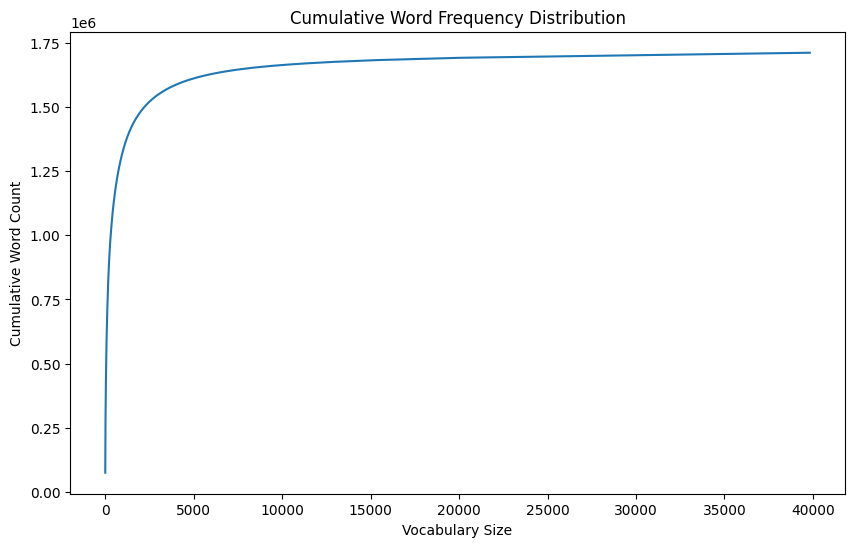

In [77]:
word_frequencies = [count for _, count in sorted_word_counts]
cumulative_frequencies = [sum(word_frequencies[:i]) for i in range(1, len(word_frequencies) + 1)]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_frequencies) + 1), cumulative_frequencies)
plt.xlabel('Vocabulary Size')
plt.ylabel('Cumulative Word Count')
plt.title('Cumulative Word Frequency Distribution')
plt.show()

If we only keep the top 5,000 - 10,000 words (num_words=5000), the curve suggests this will likely cover the vast majority of the dataset.

In [78]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_statement'])

In [79]:
# Percentage of covered words
word_coverage = sum([freq for _, freq in sorted_word_counts[:5000]]) / sum([freq for _, freq in sorted_word_counts])
print(f"Word Coverage with top 5000 words: {word_coverage:.2%}")

Word Coverage with top 5000 words: 94.15%


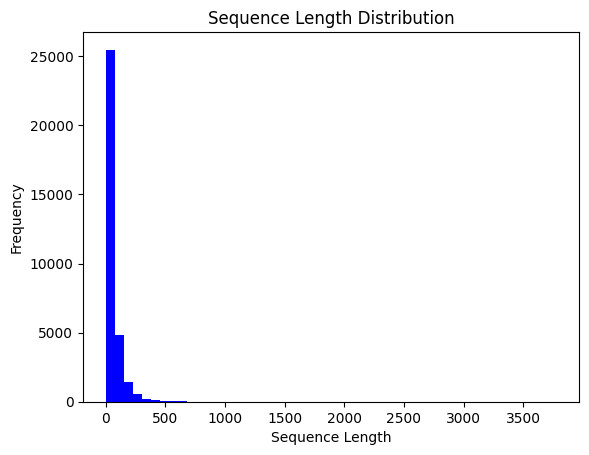

count    32699.000000
mean        52.356953
std         78.119784
min          0.000000
25%          8.000000
50%         29.000000
75%         68.000000
90%        128.000000
95%        182.000000
max       3780.000000
Name: cleaned_statement, dtype: float64


In [80]:
# Calculate sequence lengths
sequence_lengths = train_df['cleaned_statement'].apply(lambda x: len(x.split()))

# Plot distribution
import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=50, color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# Check key percentiles
print(sequence_lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95]))

Let's do 180

In [81]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_statement'])
X_val_seq = tokenizer.texts_to_sequences(val_df['cleaned_statement'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_statement'])

# Pad sequences to a uniform length
max_len = 180  # Adjust From right above
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Target labels
y_train, y_val, y_test = train_df['label'], val_df['label'], test_df['label']

In [82]:
# Print original class distribution
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({3: 10265, 2: 9660, 6: 6812, 0: 2318, 1: 1601, 5: 1470, 4: 573})


# vi. ANN Training (Sequential API/Functional API)

In [83]:
clear_session()

## a. Model Definition

In [84]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),  # Embedding layer
    LSTM(32, 
         dropout=0.2, 
         recurrent_dropout=0.2, 
         kernel_initializer=GlorotUniform(seed=42)),  # Reduced LSTM units
    Dense(16, 
          activation='relu', 
          kernel_initializer=GlorotUniform(seed=42)),  # Reduced Dense units
    Dropout(0.1),  # Dropout
    Dense(len(train_df['label'].unique()), 
          activation='softmax', 
          kernel_initializer=GlorotUniform(seed=42))  # Output layer
])

The architecture has only a single LSTM layer followed by a Dense layer.

Dropout layers after the LSTM and Dense layers reduce the risk of overfitting, specifically in the case of medium size dataset.

The number of units 32 in the LSTM and Dense layers is a reasonable choice for balancing computational cost and model capacity.

The final Dense layer with softmax activation ensures the model outputs probabilities for each of the 7 classes

In [85]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                                 
Total params: 333063 (1.27 MB)
Trainable params: 333063 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## b. Model Training


In [86]:
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# class_weight_dict = dict(enumerate(class_weights))

In [87]:
# brace urself. this will take a while.
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=21,
    batch_size=32,
    # class_weight=class_weight_dict,  # Include class weights
    verbose=1
)

Epoch 1/21


1022/1022 [==============================] - 50s 48ms/step - loss: 1.5435 - accuracy: 0.3721 - val_loss: 1.4167 - val_accuracy: 0.4460
Epoch 2/21
1022/1022 [==============================] - 48s 47ms/step - loss: 1.5407 - accuracy: 0.3627 - val_loss: 1.4411 - val_accuracy: 0.4236
Epoch 3/21
1022/1022 [==============================] - 48s 47ms/step - loss: 1.3002 - accuracy: 0.5140 - val_loss: 1.1634 - val_accuracy: 0.5650
Epoch 4/21
1022/1022 [==============================] - 48s 47ms/step - loss: 1.0901 - accuracy: 0.5703 - val_loss: 0.9754 - val_accuracy: 0.5987
Epoch 5/21
1022/1022 [==============================] - 48s 47ms/step - loss: 0.9131 - accuracy: 0.6202 - val_loss: 0.9445 - val_accuracy: 0.6153
Epoch 6/21
1022/1022 [==============================] - 48s 47ms/step - loss: 0.8214 - accuracy: 0.6741 - val_loss: 0.8520 - val_accuracy: 0.6752
Epoch 7/21
1022/1022 [==============================] - 48s 47ms/step - loss: 0.7402 - accuracy: 0.7193 - val_loss: 0.8226

The training accuracy improves steadily, reaching around 90% by the 21st epoch.

The validation accuracy plateaus at around 71.6% after epoch 10, indicating potential overfitting.

> HOWEVER

The training loss decreases consistently, showing the model is learning effectively on the training data.

The validation loss starts increasing after epoch 10, suggesting overfitting as the model begins to perform worse on unseen data.

## c. Model Evaluation

In [88]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

320/320 [==============================] - 2s 8ms/step - loss: 1.1276 - accuracy: 0.6993
Test Loss: 1.1275690793991089
Test Accuracy: 0.699285626411438


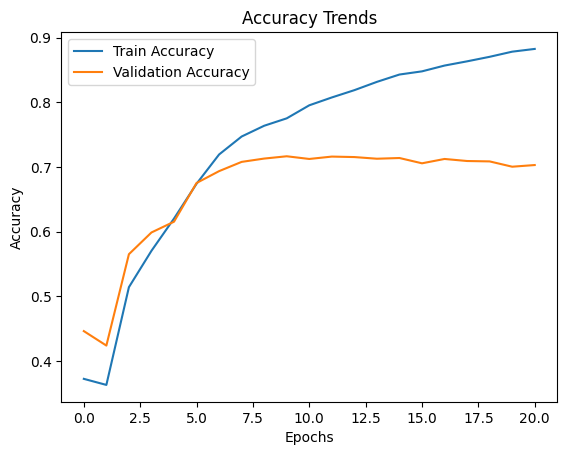

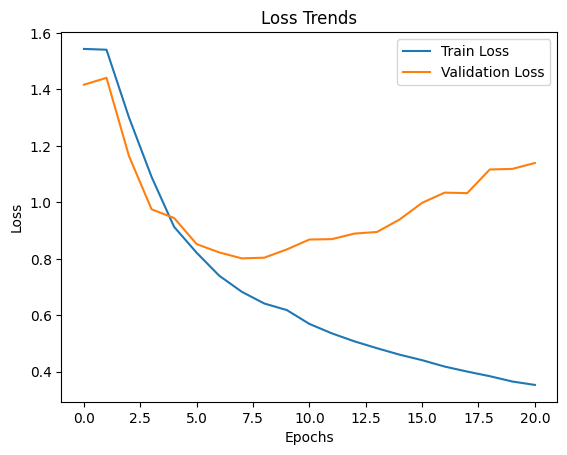

In [89]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Trends')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Trends')
plt.show()

Overfitting:

The gap between training and validation accuracy widens after epoch 10.

This is confirmed by the divergence in training and validation loss trends.

Decent Baseline Model with 71% acc.

# vii. ANN Improvement (Sequential API/Functional API)

In [90]:
clear_session()

## a. Model Definition

In [91]:
model = Sequential([
    # Embedding layer
    Embedding(input_dim=5000, output_dim=128, input_length=180),  # Random embeddings; replace with pretrained if available

    # GRU layers
    GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),  # First GRU layer
    GRU(32, dropout=0.3, recurrent_dropout=0.3),  # Second GRU layer

    # Hidden layer with Leaky ReLU
    Dense(16),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='softmax')  # 7 classes for multiclass classification
])

The input vocabulary is limited to the top 5000 words, and we use a 128-dimensional embedding to capture semantic relationships. 

Pretrained embeddings could possibly further enhance performance.

Stacked GRUs allow the model to learn sequential dependencies and context from the input data. The first GRU layer captures broader patterns, while the second focuses on finer details.

Hidden layer with the Leaky ReLU activation helps avoid vanishing gradients during backpropagation, but likely not suitable for dataset of this size. Should've used ones that can handle medium size.

In [92]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical for integer labels
    metrics=['accuracy']
)

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 128)          640000    
                                                                 
 gru (GRU)                   (None, 180, 64)           37248     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16)                0         
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                        

## b. Model Training


In [94]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

EarlyStopping ensures the model stops training when it ceases to improve, while ReduceLROnPlateau dynamically adjusts the learning rate for better convergence.

ReduceLROnPlateau: Adjusts learning rate when progress slows.

In [95]:
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=25,  # EarlyStopping will stop earlier if necessary
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
1022/1022 [==============================] - 108s 103ms/step - loss: 1.6433 - accuracy: 0.3169 - val_loss: 1.6074 - val_accuracy: 0.2954 - lr: 0.0010
Epoch 2/25
1022/1022 [==============================] - 110s 108ms/step - loss: 1.5833 - accuracy: 0.3321 - val_loss: 1.7515 - val_accuracy: 0.2954 - lr: 0.0010
Epoch 3/25
1022/1022 [==============================] - 113s 110ms/step - loss: 1.3435 - accuracy: 0.4600 - val_loss: 0.9448 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 4/25
1022/1022 [==============================] - 113s 110ms/step - loss: 0.8189 - accuracy: 0.7056 - val_loss: 0.7204 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 5/25
1022/1022 [==============================] - 112s 110ms/step - loss: 0.6776 - accuracy: 0.7595 - val_loss: 0.8320 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 6/25
1022/1022 [==============================] - 115s 112ms/step - loss: 0.6042 - accuracy: 0.7882 - val_loss: 0.7589 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 7/25
1022/1022 [============

The Leaky ReLU activation might have helped achieve faster convergence compared to plain ReLU, especially in the early epochs.

The ReduceLROnPlateau callback was triggered, lowering the learning rate after the loss plateaued, which likely stabilized the validation performance.

## c. Model Evaluation

In [96]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

320/320 [==============================] - 5s 17ms/step - loss: 0.7202 - accuracy: 0.7382
Test Loss: 0.7201923131942749
Test Accuracy: 0.7382327318191528


the GRU model with Leaky ReLU has improved performance, especially on the test set with a Test Accuracy of ~74%.

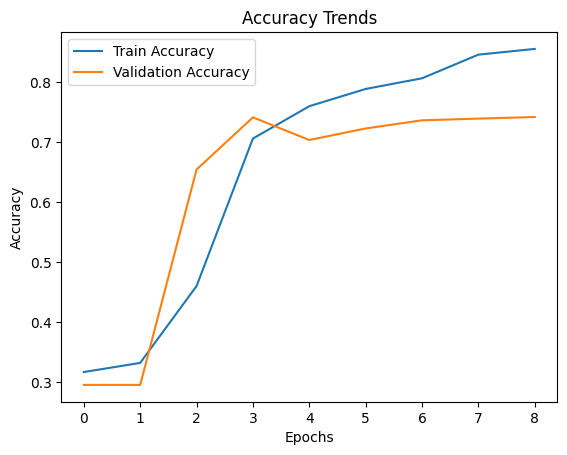

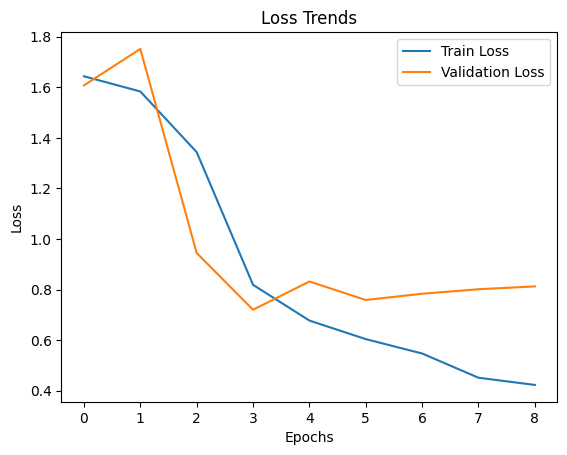

In [97]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Trends')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Trends')
plt.show()

In [98]:
# classification report

y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

320/320 [==============================] - 6s 17ms/step


In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       725
           1       0.75      0.72      0.73       500
           2       0.71      0.65      0.68      3019
           3       0.91      0.92      0.91      3208
           4       0.89      0.14      0.24       179
           5       0.28      0.17      0.21       459
           6       0.62      0.73      0.67      2129

    accuracy                           0.74     10219
   macro avg       0.69      0.60      0.60     10219
weighted avg       0.74      0.74      0.73     10219



Label Mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}

Overall Accuracy:

The model achieves an overall accuracy of 75%, which is decent given the multi-class classification challenge.

Class Performance:

> Class 3 (Normal): Performs the best, with 90% precision, 92% recall, and 91% F1-score. This is likely due to a high number of correctly classified samples and a larger number of instances in this class.

> Class 4 (Personality Disorder): Precision is very high (98%), but recall is low (35%). This indicates the model predicts this class rarely but very accurately when it does.

> Class 5 (Stress): Shows weaker performance across all metrics, with a precision of 46%, recall of 40%, and F1-score of 43%.

> Class 6 (Suicidal): Moderate performance with a precision of 66%, recall of 62%, and F1-score of 64%.

> Class 2 (Depression): A mixed performance with lower precision (66%) but relatively better recall (73%).

Averages performance metrics equally across all classes. Precision is 76%, recall is 65%, and F1-score is 68%, indicating imbalance in per-class performance.

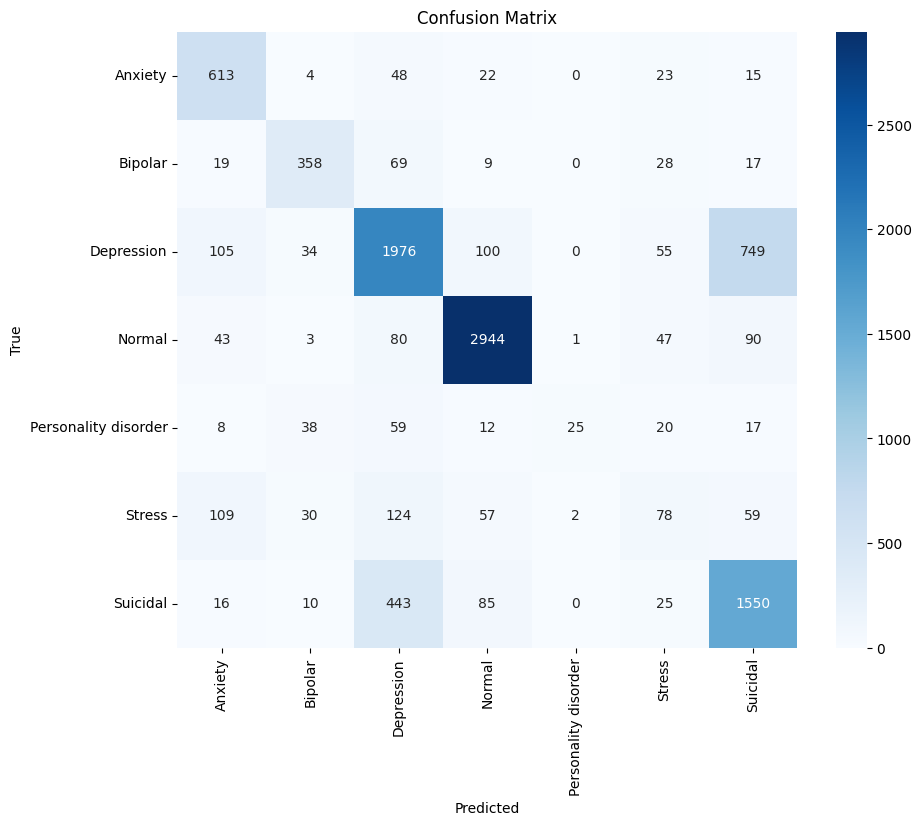

In [100]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## d. Strength and Weakness of the model

The diagonal elements (e.g., 562 for Anxiety, 357 for Bipolar, etc.) represent the number of correctly classified samples for each class.

Class 3 (Normal) has the highest true positives, indicating strong performance for this class.

Class 4 (Personality Disorder) has relatively few true positives (63), reflecting poor performance for this class.

> HOWEVER ===

Class 6 (Suicidal):
A significant number of samples (650) are misclassified as Depression.

Class 2 (Depression):
Many instances are misclassified as Normal (115) or Suicidal (549), indicating overlap or ambiguity between these classes.

Class 5 (Stress):
Misclassified as Depression (131) and Anxiety (42), suggesting a potential overlap in features or lack of distinction.

Depression, Stress, and Anxiety: These are highly interconnected mental health conditions, and the confusion among these labels might arise due to shared symptoms or that they might share similar features/words in their statements.

# viii. Model Saving

In [101]:
# Save the model in TensorFlow SavedModel format
model.save('model')

In [102]:
# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as 'tokenizer.pkl'")

# ix. Model Inference

```python
new_texts = ["I feel really anxious and stressed.", 
             "Life is going great, feeling very happy today. I have work to do but I am excited to do it.",
             "This is it. I am done. I am not doing this anymore. I am tired of this.",
             "I'm really happy today"]

class_labels = {
    0: 'Anxiety', 
    1: 'Bipolar', 
    2: 'Depression', 
    3: 'Normal', 
    4: 'Personality disorder', 
    5: 'Stress', 
    6: 'Suicidal'
}

# Map predicted classes to their labels
predicted_labels = [class_labels[cls] for cls in predicted_classes]
print("Predicted Labels:", predicted_labels)

```

PREDICTION :

> Predicted Labels: ['Anxiety', 'Normal', 'Suicidal', 'Normal']

# x. Conclusion

We have successfully developed a machine learning model capable of classifying text data into multiple mental health categories based on sentiment and context. This model may be used to automate the analysis of unstructured statement/text (with predominantly social medias' text) data, which often serves as a reflection of human emotions and mental well-being. 

The model demonstrates an overall accuracy of 74%, with particularly strong performance in identifying the "Normal" category, though challenges remain in differentiating overlapping mental health conditions such as "Depression," "Stress," and "Anxiety."

A quick fix would be to scale down the number of classes and merge. But this will require further study.

---
Key Outcomes:

Mental Distress Detection:

    The model shows potential for identifying mental distress based on textual input, which could assist mental health professionals and organizations in monitoring individuals' mental well-being at scale.

Applications in Mental Health Tools:

    This classifier could serve as a foundational component for chatbots or mobile applications designed to monitor users' emotional health, offering tailored interventions or suggestions for mental health improvement. Or if need be, directly refer users to humans (professionals).

Research on Mental Health Trends:

    By automating the classification of large-scale data, this model may enable researchers to analyze collective emotional trends during significant events, aiding studies on mental health and well-being.

## a. Recommendations for future improvements

For future improvement, I would recommend explore the following:

1. Focus on Class Differentiation:

    Use feature importance analysis (e.g., SHAP or permutation importance) to identify which features contribute most to confusion between classes like Depression, Stress, and Anxiety.

2. Address Class Imbalance:

    Oversample underrepresented classes (e.g., Personality Disorder, Stress) using techniques like SMOTE or wight inside the model def to balance the dataset.

3. Custom Loss Function:

    Use a weighted loss function during training to penalize misclassifications in critical classes like Suicidal or Personality Disorder more heavily.

4. Fine-Tune Hyperparameters:

    Experiment with different architectures, dropout rates, or optimizers to refine the model's performance.

5. Improve Dataset Quality:

    If possible, collect more data or enhance data quality for underrepresented classes (e.g., Personality Disorder, Stress).

## b. Misc

> Top words for Anxiety: [('not', 8133), ('anxiety', 3590), ('like', 3045), ('feel', 2609), ('get', 1979), ('time', 1953), ('know', 1900), ('day', 1751), ('really', 1490), ('year', 1416)]

Top words for Normal: [('not', 4406), ('like', 1298), ('want', 1224), ('time', 925), ('get', 918), ('really', 857), ('would', 808), ('go', 800), ('one', 798), ('know', 797)]

> Top words for Depression: [('not', 49375), ('like', 18094), ('feel', 17941), ('want', 12584), ('know', 11957), ('life', 11545), ('get', 10400), ('time', 9521), ('even', 9037), ('no', 8621)]

Top words for Suicidal: [('not', 37796), ('want', 11161), ('like', 9215), ('feel', 8562), ('life', 8204), ('know', 7419), ('no', 6175), ('would', 5742), ('get', 5706), ('even', 5214)]

> Top words for Stress: [('not', 4516), ('like', 1510), ('feel', 1307), ('stress', 1157), ('get', 1138), ('time', 1086), ('know', 1021), ('would', 751), ('day', 751), ('work', 727)]

Top words for Bipolar: [('not', 7885), ('like', 2757), ('feel', 2461), ('know', 1789), ('get', 1746), ('bipolar', 1712), ('time', 1694), ('year', 1394), ('would', 1380), ('really', 1371)]

> Top words for Personality disorder: [('not', 3307), ('like', 1410), ('feel', 1042), ('people', 1033), ('know', 764), ('would', 663), ('even', 648), ('want', 601), ('time', 575), ('get', 547)]